In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

import dill
import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
import prettypyplot as pplt

In [3]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [4]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [5]:
sys.path.insert(0, "/project/dinner/scguo/kaiB/src")
import statistics

import data
import utils

In [6]:
plt.style.use("custom")  # custom style sheet
plt.style.use("high-contrast")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [7]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

# Load data

In [8]:
home_dir = "/project/dinner/scguo/kaiB"

In [9]:
cvs_all_ts, weights_all_ts = [], []
qlag, qmem = 100, 1
for t in [87, 89, 91]:
    cvs, weights = data.load_all(t)
    cvs_all_ts.append(cvs)
    weights_all_ts.append(weights)

In [37]:
def load_currents(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    data_dir = f"{base_dir}/data"
    js = dict()
    js_withc = dict()
    for cv in ["blue", "green", "orange", "q_core", "q_gs_all", "q_gs", "q_fs_all", "q_fs", "qp"]:
        j = np.load(f"{data_dir}/j_gs2fs_{cv}.npy")
        js[cv] = -j
        if cv in ["blue", "green", "orange"]:
            js[cv] = -j
        j = np.load(f"{data_dir}/j_gs2fs_withc_{cv}.npy")
        if cv in ["blue", "green", "orange"]:
            js_withc[cv] = -j
        js_withc[cv] = j
    js['q_diff'] = js['q_fs'] - js['q_gs']
    js_withc['q_diff'] = js_withc['q_fs'] - js_withc['q_gs']
    return js, js_withc

In [38]:
js_all_ts, js_withc_all_ts = [], []
for t in (87, 89, 91):
    js, js_withc = load_currents(t)
    js_all_ts.append(js)
    js_withc_all_ts.append(js_withc)

In [12]:
qp_all_ts, qp_withc_all_ts = [], []
for t in [87, 89, 91]:
    with open(f"{home_dir}/dga/new_{t}/data/qp_gs2fs.pkl", mode="rb") as f:
        qp = dill.load(f)[(qlag, qmem)]
        qp_all_ts.append(qp)
    qp_withc_all_ts.append(np.load(f"{home_dir}/dga/new_{t}/data/qp_gs2fs_withc.npy"))

In [13]:
labels = dict(
    blue=r"$\beta4_{\mathrm{gs}}\longleftrightarrow\alpha3_{\mathrm{fs}}$",
    green=r"$\alpha3_{\mathrm{gs}}\longleftrightarrow\beta4_{\mathrm{fs}}$",
    orange=r"$\alpha2_{\mathrm{gs}}\longleftrightarrow\beta3_{\mathrm{fs}}$",
    c0=r"$\beta3_{\mathrm{gs}}\longleftrightarrow\alpha2_{\mathrm{fs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{fs, C}}-Q_{\mathrm{gs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1.3, 1),
    green=(-1, 1.3),
    orange=(-1, 1.3),
    c0=(-1.3, 1),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

# Plot 2D currents

In [21]:
def plot_current(
    cv1,
    cv2,
    jx,
    jy,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    vmin=None,
    vmax=None,
    cm_j="viridis",
    ax=None,
    plot_log=False,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)
    
    # KDE bin fluxes
    jx_binned, _, _ = utils.kdesum2d(
        cv1,
        cv2,
        jx,
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = utils.kdesum2d(
        cv1,
        cv2,
        jy,
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd flux
    magnitude = (jx_binned**2 + jy_binned**2) ** 0.5
    if plot_log:
        color = np.log(magnitude)
    else:
        color = magnitude
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / magnitude).T,
        (jy_binned / magnitude).T,
        color.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
        norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
    )
    return ax, quiv

/scratch/local/jobs/18459697/ipykernel_784238/4098562615.py:18: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


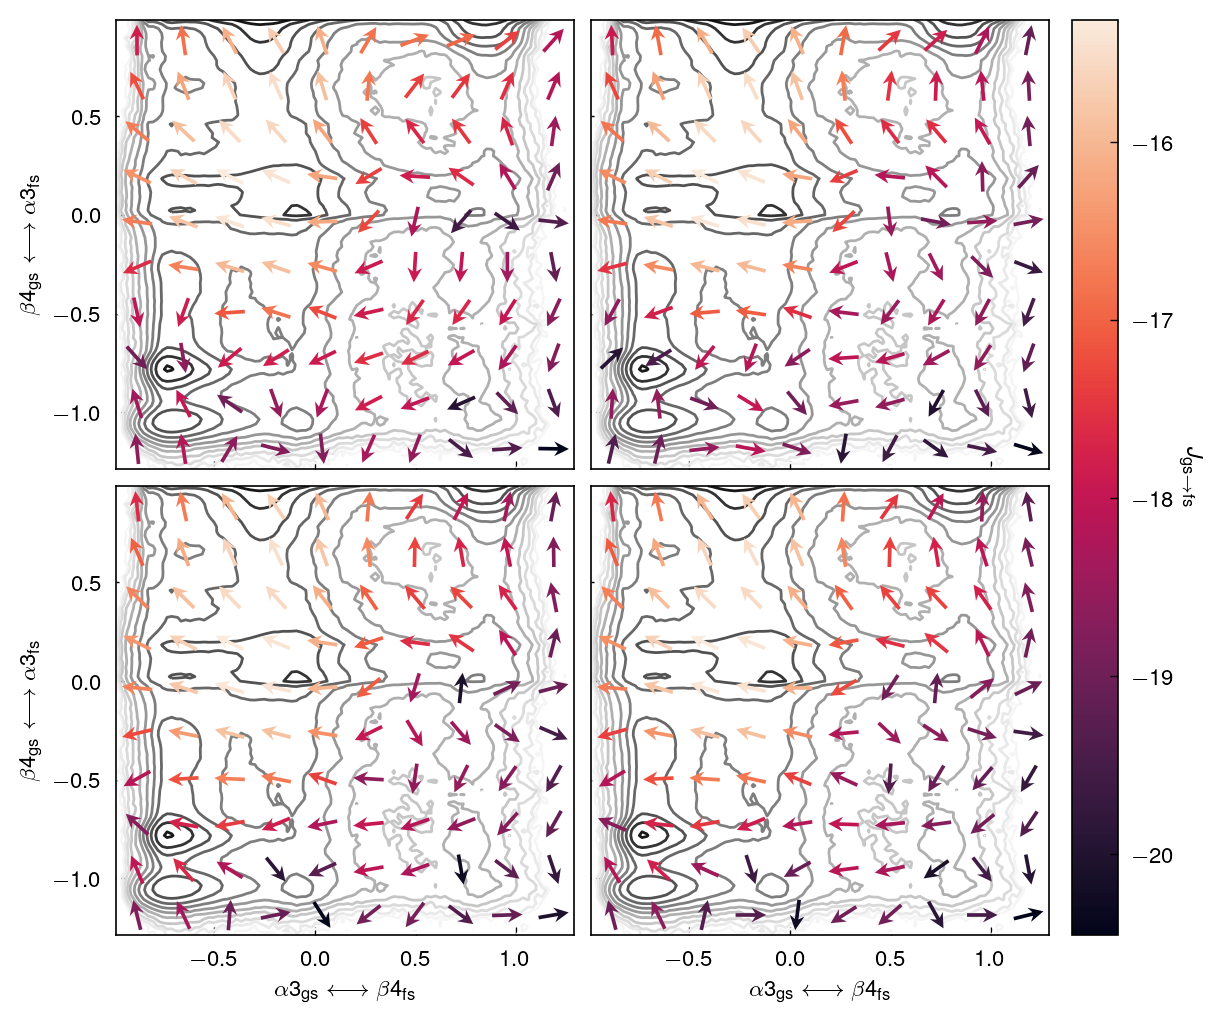

In [48]:
fig, axes = plt.subplots(2, 2, dpi=200, figsize=(6, 5), sharex=True, sharey=True, constrained_layout=True)
cv1, cv2 = "green", "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
cv1_delay = cvs_all_ts[0][cv1]
cv2_delay = cvs_all_ts[0][cv2]
weights = np.broadcast_to(weights_all_ts[0][..., None], cv1_delay.shape)
hist = extq.projection.density2d(
    cv1_delay,
    cv2_delay,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pmf = -np.log(hist) - np.min(-np.log(hist))
clines = np.arange(0, 13)

for i, ax in enumerate(axes.flat):
    jcv1 = js_all_ts[0][cv1][i]
    jcv2 = js_all_ts[0][cv2][i]
    ax.contour(xc, yc, pmf.T, cmap="Greys_r", levels=clines, linewidths=1)
    _, quiv = plot_current(
        cv1_delay,
        cv2_delay,
        -jcv1,
        -jcv2,
        weights,
        *lims[cv1],
        *lims[cv2],
        10,
        cm_j="rocket",
        ax=ax,
        plot_log=True
    )
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(quiv, ax=axes[:, -1])
cb.set_label(label=r"$J_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

/scratch/local/jobs/18459697/ipykernel_784238/3871105885.py:18: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


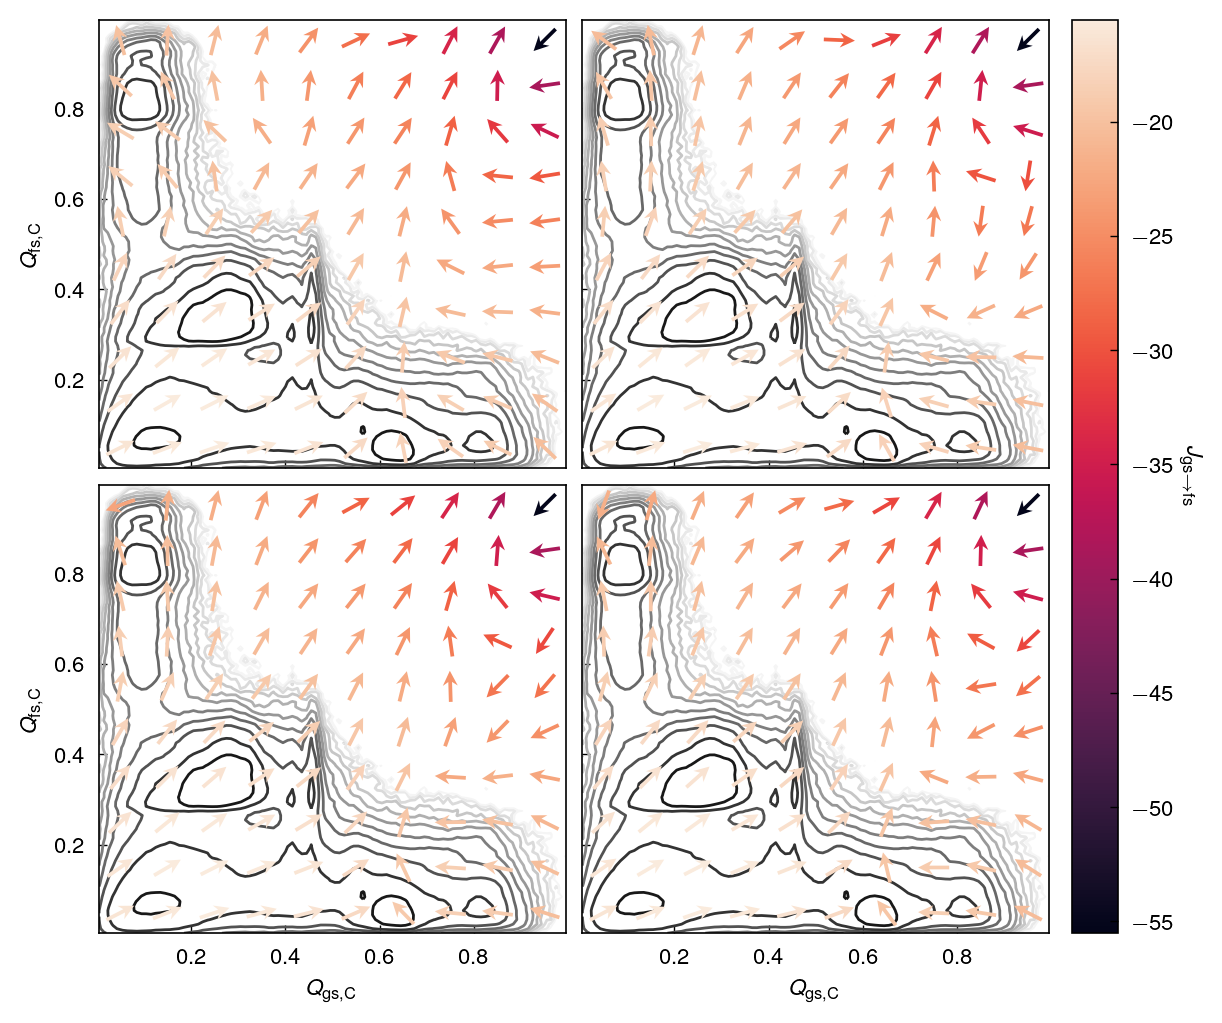

In [51]:
fig, axes = plt.subplots(2, 2, dpi=200, figsize=(6, 5), sharex=True, sharey=True, constrained_layout=True)
cv1, cv2 = "q_gs", "q_fs"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
cv1_delay = cvs_all_ts[0][cv1]
cv2_delay = cvs_all_ts[0][cv2]
weights = np.broadcast_to(weights_all_ts[0][..., None], cv1_delay.shape)
hist = extq.projection.density2d(
    cv1_delay,
    cv2_delay,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pmf = -np.log(hist) - np.min(-np.log(hist))
clines = np.arange(0, 13)

for i, ax in enumerate(axes.flat):
    jcv1 = js_all_ts[0][cv1][i]
    jcv2 = js_all_ts[0][cv2][i]
    ax.contour(xc, yc, pmf.T, cmap="Greys_r", levels=clines, linewidths=1)
    _, quiv = plot_current(
        cv1_delay,
        cv2_delay,
        jcv1,
        jcv2,
        weights,
        *lims[cv1],
        *lims[cv2],
        10,
        cm_j="rocket",
        ax=ax,
        plot_log=True
    )
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(quiv, ax=axes[:, -1])
cb.set_label(label=r"$J_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

In [ ]:
fig, axes = plt.subplots(
    ncols=3, dpi=300, figsize=(7, 2.25), sharex=True, sharey=True, constrained_layout=True
)

cv1, cv2 = "q_gs", "q_fs"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, weights, js in zip(axes, cvs_all_ts, weights_all_ts, js_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    weights = np.broadcast_to(weights[..., None], cv1_delay.shape)
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        weights,
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    clines = np.arange(0, 14)
    ax.contour(xc, yc, pmf.T, cmap="Greys_r", levels=clines, linewidths=1)

    i = 0  # lag = 1
    jcv1 = js[cv1][i]
    jcv2 = js[cv2][i]
    _, quiv = plot_current(
        cv1_delay,
        cv2_delay,
        jcv1,
        jcv2,
        weights,
        *lims[cv1],
        *lims[cv2],
        10,
        cm_j="rocket",
        ax=ax,
        plot_log=True,
        vmin=-20,
        vmax=-15,
    )
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
cb = plt.colorbar(quiv, ax=axes[-1])
cb.set_label(label=r"$J_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

/scratch/local/jobs/18459697/ipykernel_784238/561879797.py:20: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


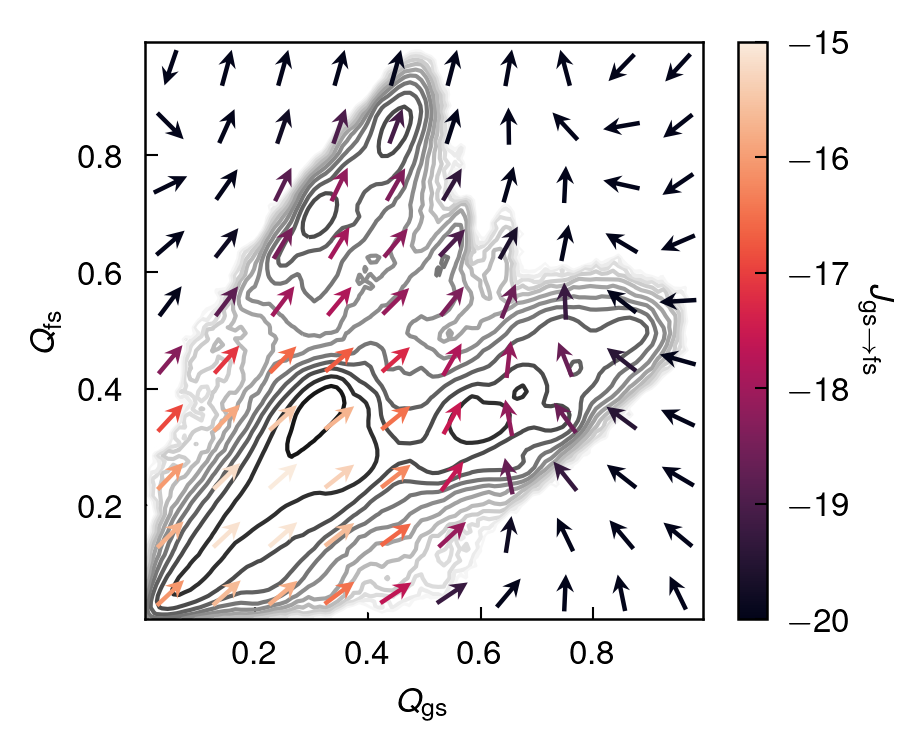

In [58]:
fig = plt.figure(dpi=300, figsize=(3, 2.5))
ax = plt.gca()

cv1, cv2 = "q_gs_all", "q_fs_all"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
cv1_delay = cvs_all_ts[0][cv1]
cv2_delay = cvs_all_ts[0][cv2]
weights = np.broadcast_to(weights_all_ts[0][..., None], cv1_delay.shape)
hist = extq.projection.density2d(
    cv1_delay,
    cv2_delay,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pmf = -np.log(hist) - np.min(-np.log(hist))
clines = np.arange(0, 14)
ax.contour(xc, yc, pmf.T, cmap="Greys_r", levels=clines, linewidths=1)

i = 0  # lag = 1
jcv1 = js_all_ts[0][cv1][i]
jcv2 = js_all_ts[0][cv2][i]
_, quiv = plot_current(
    cv1_delay,
    cv2_delay,
    jcv1,
    jcv2,
    weights,
    *lims[cv1],
    *lims[cv2],
    10,
    cm_j="rocket",
    ax=ax,
    plot_log=True,
    vmin=-20,
    vmax=-15,
)
ax.set_xlabel(labels[cv1])
ax.set_ylabel(labels[cv2])
cb = plt.colorbar(quiv, ax=ax)
cb.set_label(label=r"$J_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

/scratch/local/jobs/18459697/ipykernel_784238/3573569848.py:20: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


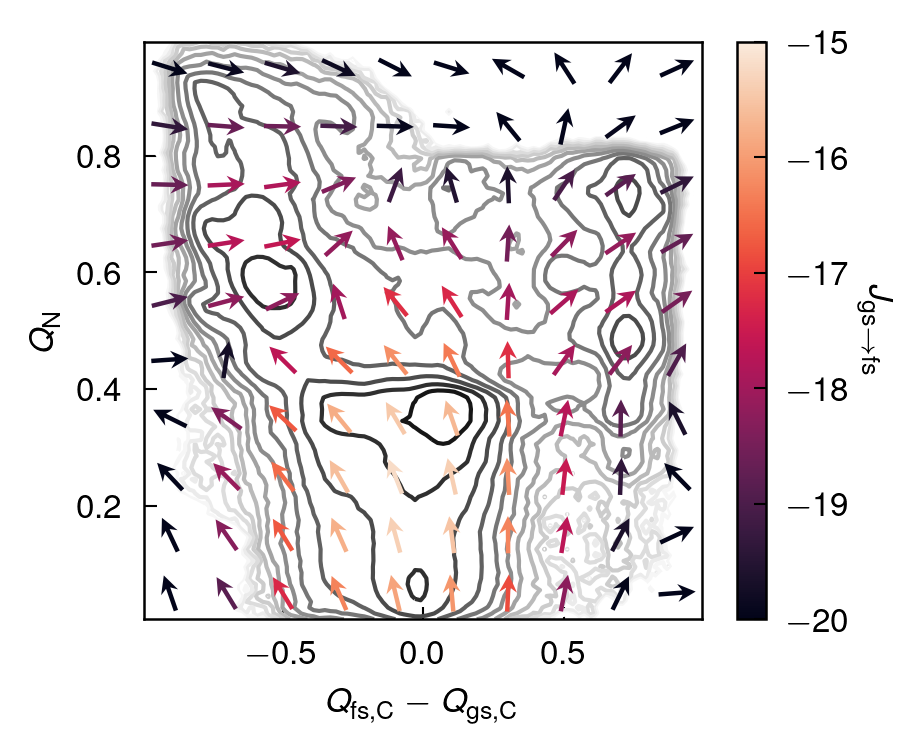

In [61]:
fig = plt.figure(dpi=300, figsize=(3, 2.5))
ax = plt.gca()

cv1, cv2 = "q_diff", "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
cv1_delay = cvs_all_ts[0][cv1]
cv2_delay = cvs_all_ts[0][cv2]
weights = np.broadcast_to(weights_all_ts[0][..., None], cv1_delay.shape)
hist = extq.projection.density2d(
    cv1_delay,
    cv2_delay,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pmf = -np.log(hist) - np.min(-np.log(hist))
clines = np.arange(0, 14)
ax.contour(xc, yc, pmf.T, cmap="Greys_r", levels=clines, linewidths=1)

i = 0  # lag = 1
jcv1 = js_all_ts[0]["q_fs"][i] - js_all_ts[0]["q_gs"][i]
jcv2 = js_all_ts[0][cv2][i]
_, quiv = plot_current(
    cv1_delay,
    cv2_delay,
    jcv1,
    jcv2,
    weights,
    *lims[cv1],
    *lims[cv2],
    10,
    cm_j="rocket",
    ax=ax,
    plot_log=True,
    vmin=-20,
    vmax=-15,
)
ax.set_xlabel(labels[cv1])
ax.set_ylabel(labels[cv2])
cb = plt.colorbar(quiv, ax=ax)
cb.set_label(label=r"$J_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

In [24]:
def plot_current_ts(
    axes, cv1, cv2, js_all_ts, nj=10, cm_j="rocket", plot_log=True, vmin=None, vmax=None
):
    xe = np.linspace(*lims[cv1], 101)
    ye = np.linspace(*lims[cv2], 101)
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    clines = np.arange(0, 14)

    for ax, cvs, w, js in zip(axes, cvs_all_ts, weights_all_ts, js_all_ts):
        cv1_delay = cvs[cv1]
        cv2_delay = cvs[cv2]
        weights = np.broadcast_to(w[..., None], cv1_delay.shape)
        hist = extq.projection.density2d(
            cv1_delay,
            cv2_delay,
            weights,
            xe,
            ye,
        )
        hist = scipy.ndimage.gaussian_filter(hist, sigma=1.0, mode="constant")
        pmf = -np.log(hist) - np.min(-np.log(hist))
        ax.contour(xc, yc, pmf.T, cmap="Greys_r", levels=clines, linewidths=1)

        i = 0  # lag = 1
        jcv1 = js[cv1][i]
        jcv2 = js[cv2][i]
        _, quiv = plot_current(
            cv1_delay,
            cv2_delay,
            jcv1,
            jcv2,
            weights,
            *lims[cv1],
            *lims[cv2],
            nj,
            cm_j=cm_j,
            ax=ax,
            plot_log=plot_log,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_xlabel(labels[cv1])
        ax.set_ylabel(labels[cv2])
        ax.label_outer()
    cb = plt.colorbar(quiv, ax=axes[-1])
    cb.set_label(label=r"$J_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

/scratch/local/jobs/18574283/ipykernel_1262330/2110737726.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


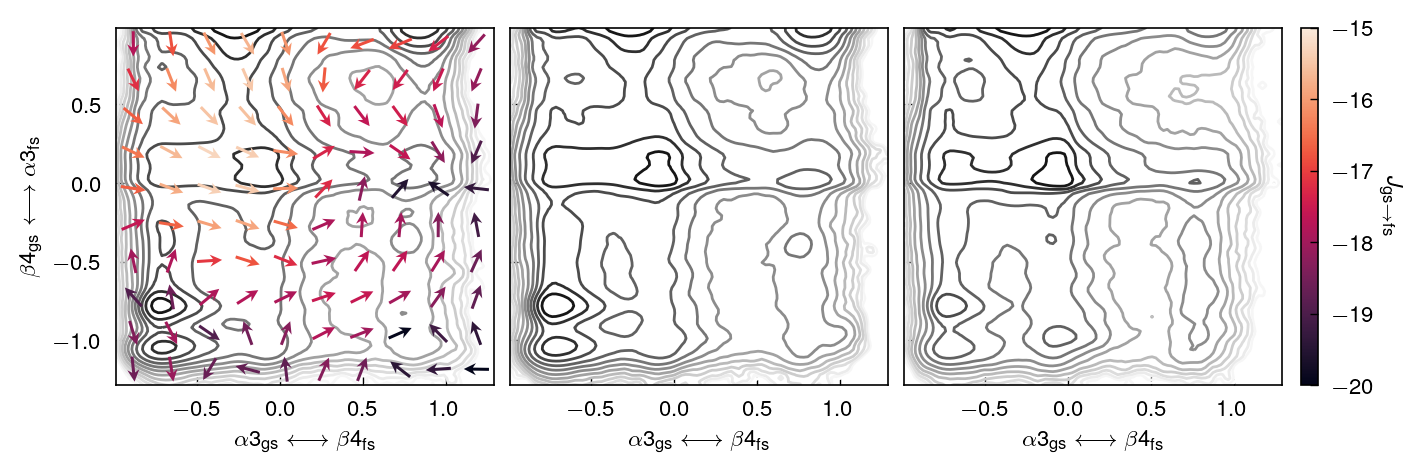

In [25]:
fig, axes = plt.subplots(
    1, 3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
plot_current_ts(axes, "green", "blue", js_all_ts, vmin=-20, vmax=-15)

/scratch/local/jobs/18574283/ipykernel_1262330/2110737726.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


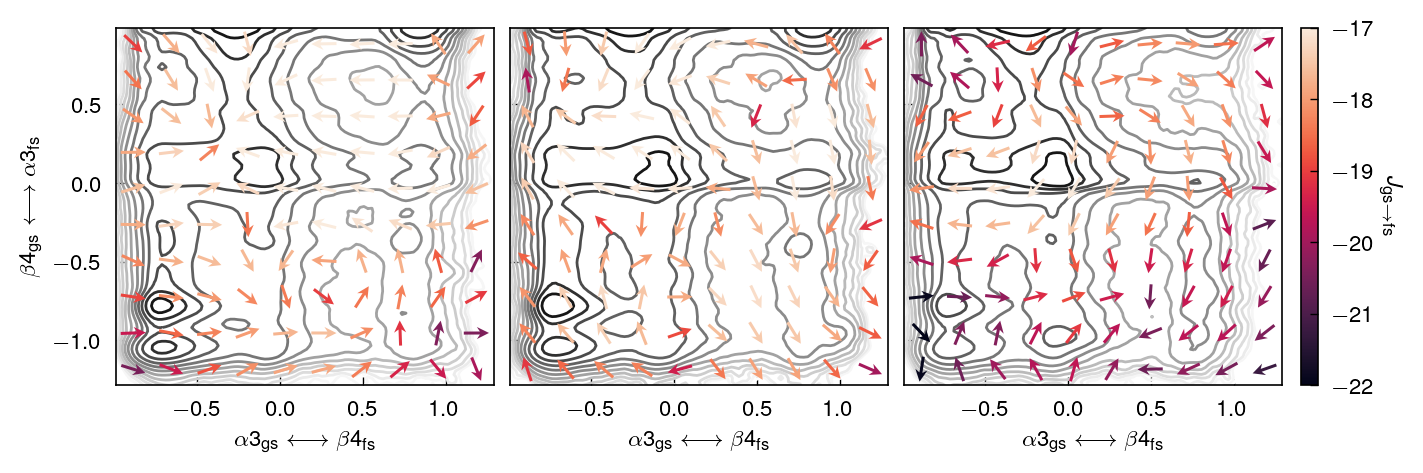

In [39]:
fig, axes = plt.subplots(
    1, 3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
plot_current_ts(axes, "green", "blue", js_withc_all_ts, vmin=-22, vmax=-17)

/scratch/local/jobs/18574283/ipykernel_1262330/2110737726.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


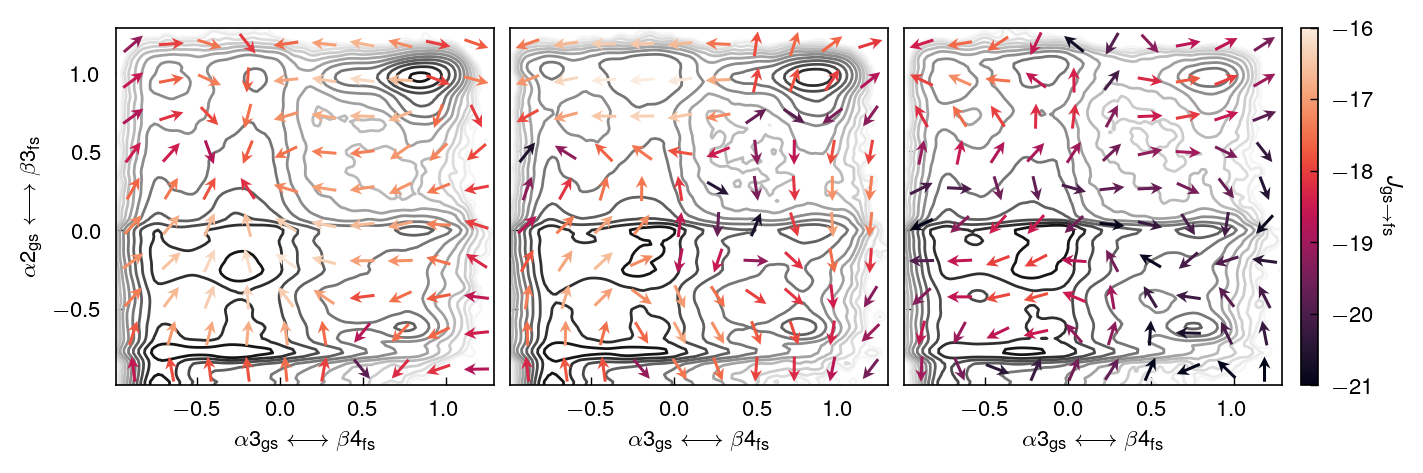

In [41]:
fig, axes = plt.subplots(
    1, 3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
plot_current_ts(axes, "green", "orange", js_withc_all_ts, vmin=-21, vmax=-16)

/scratch/local/jobs/18574283/ipykernel_1262330/2110737726.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


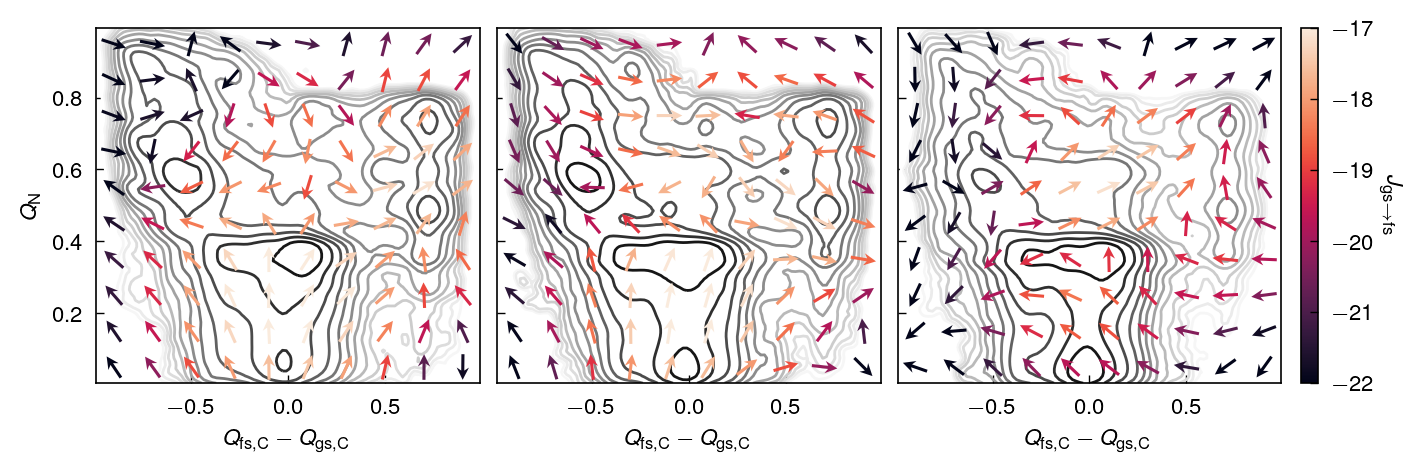

In [40]:
fig, axes = plt.subplots(
    1, 3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
plot_current_ts(axes, "q_diff", "q_core", js_withc_all_ts, vmin=-22, vmax=-17)

# Plot reactive current through isocommittor surfaces